# ACML Lab 2: Convolutional Autoencoders
Sree Kotala i6206796
Michal Kalbarczyk i6223513

In [1]:
#Importing the necessary packages.
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

import PIL
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the dataset from a numpy file; dataset taken from: https://www.kaggle.com/datasets/guesejustin/cifar10-keras-files-cifar10load-data 
data = np.load("cifar-10.npz")
filenames = ['x_train', 'y_train', 'x_test', 'y_test']
nps = []

for filename in filenames:
    nps.append(data[filename])
    
train_images, train_labels, test_images, test_labels = nps

## Util. function for showing feature maps 

In [3]:
# a function for displaying feature maps given a model and test data
def construct_feature_map(model, test_data):
    blocks = []
    for i in range(len(model.layers)):
        if "conv" in model.layers[i].name:
            blocks.append(i)

    outputs = [model.layers[i].output for i in blocks]
    model = Model(inputs=model.inputs, outputs=outputs)
    feature_map = model.predict(test_data[:2])

    # Show original image
    plt.title("Original image")
    plt.imshow(test_data[0], cmap="gray")

    for i, fmap in zip(blocks, feature_map):
        fig = plt.figure(figsize=(20,15))

        #https://stackoverflow.com/a/12444777
        fig.suptitle(f"Feature map for convolutional layer {i}", fontsize=20)
        for i in range(1, fmap[0].shape[2]+1):
            plt.subplot(8,8,i)
            plt.imshow(fmap[0,:,:,i-1], cmap='gray')

    plt.show()

## Reconstruction

In [4]:
#Prepping transformation(s)

datagen_norm = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
)

# Combine the data -> done to overcome the silly 50k/10k split
X = np.concatenate((train_images, test_images))
y = np.concatenate((train_labels, test_labels))

# Normalize the data
trans_norm = datagen_norm.flow(X, batch_size=len(X))
X = trans_norm.next()


# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

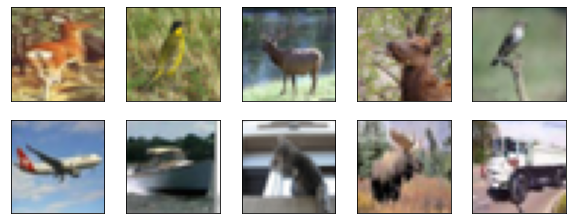

In [5]:
# Plot the images as a sanity check
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
plt.show()

In [35]:
# Build the model
class Autoencoder(Model):

    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Conv2D(16, (3, 3), activation='relu', padding="same", strides=1, input_shape=(32, 32, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(12, (3, 3), activation='relu', padding="same", strides=1),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(16, (3,3), activation='relu', padding="same", strides=1)
        ])

        self.decoder = tf.keras.Sequential([
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(12, (3, 3), activation='relu', padding="same", strides=1),
            layers.UpSampling2D(size=(2,2)),
            layers.Conv2D(3, (3, 3), activation='relu', padding="same", strides=1)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [36]:
# Compile the model
autoencoder = Autoencoder()
autoencoder.encoder.summary()
autoencoder.compile(optimizer='adam',
                    loss=losses.MeanSquaredError(),
                    metrics=['mse', 'accuracy'])

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 16, 16, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 12)        1740      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 8, 8, 12)         0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 8, 8, 32)          3488      
                                                                 
Total params: 5,676
Trainable params: 5,676
Non-train

In [37]:
# Train the model
history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=64,
                          validation_data=(X_val, X_val))

Epoch 1/10
750/750 [==============================] - 43s 57ms/step - loss: 0.0141 - mse: 0.0141 - accuracy: 0.6498 - val_loss: 0.0066 - val_mse: 0.0066 - val_accuracy: 0.7355
Epoch 2/10
750/750 [==============================] - 39s 51ms/step - loss: 0.0060 - mse: 0.0060 - accuracy: 0.7509 - val_loss: 0.0055 - val_mse: 0.0055 - val_accuracy: 0.7606
Epoch 3/10
750/750 [==============================] - 38s 51ms/step - loss: 0.0053 - mse: 0.0053 - accuracy: 0.7664 - val_loss: 0.0052 - val_mse: 0.0052 - val_accuracy: 0.7643
Epoch 4/10
750/750 [==============================] - 40s 53ms/step - loss: 0.0050 - mse: 0.0050 - accuracy: 0.7752 - val_loss: 0.0048 - val_mse: 0.0048 - val_accuracy: 0.7703
Epoch 5/10
750/750 [==============================] - 40s 53ms/step - loss: 0.0047 - mse: 0.0047 - accuracy: 0.7802 - val_loss: 0.0048 - val_mse: 0.0048 - val_accuracy: 0.7919
Epoch 6/10
750/750 [==============================] - 36s 48ms/step - loss: 0.0045 - mse: 0.0045 - accuracy: 0.7851 - va

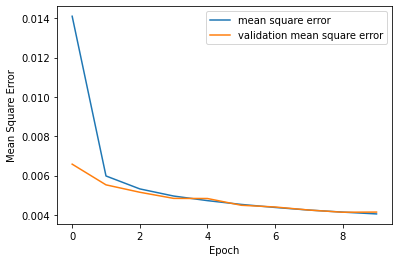

In [38]:
# Plot the valuation metrics
plt.plot(history.history['mse'], label='mean square error')
plt.plot(history.history['val_mse'], label = 'validation mean square error')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend(loc='upper right')

In [39]:
# Make the predictions
predictions = autoencoder.predict(X_test[:])

# Evaluate the predictions 
evaluation = autoencoder.evaluate(predictions, X_test)
print(f"\nLoss: {round(evaluation[0],4)}\nMSE: {round(evaluation[1],4)}\nAccuracy: {round(evaluation[2],4)}")

188/188 [==============================] - 1s 8ms/step - loss: 0.0060 - mse: 0.0060 - accuracy: 0.7639

Loss: 0.006
MSE: 0.006
Accuracy: 0.7639


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


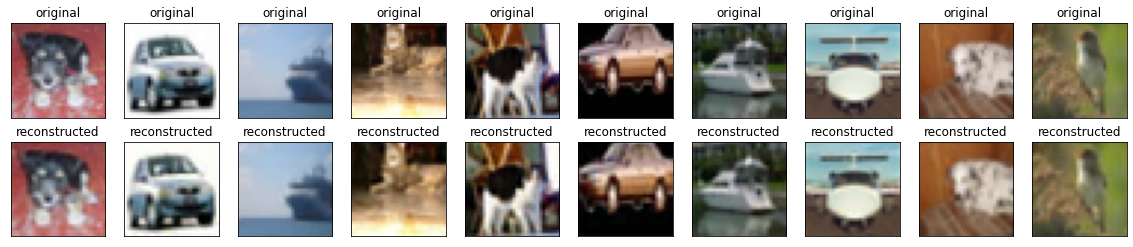

In [17]:
# Check the predictions
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i])
    plt.title("original")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    plt.title("reconstructed")
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 32)        4640      
                                                                 
Total params: 5,088
Trainable params: 5,088
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 311ms/step


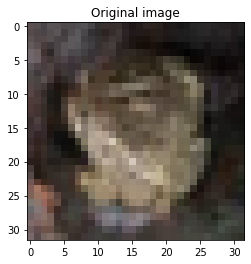

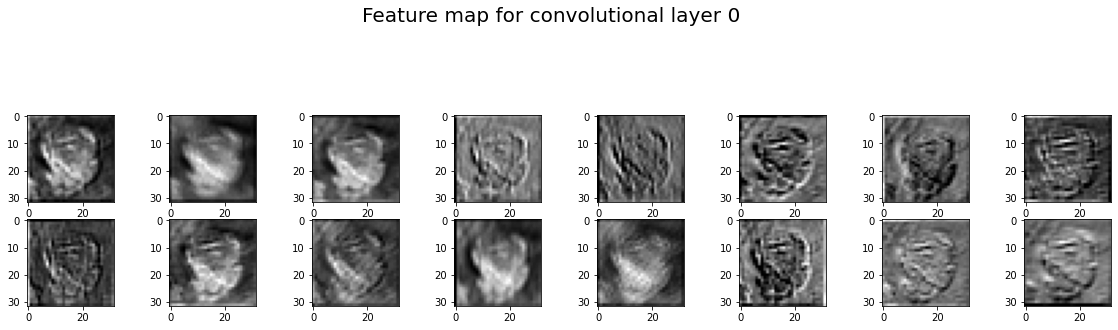

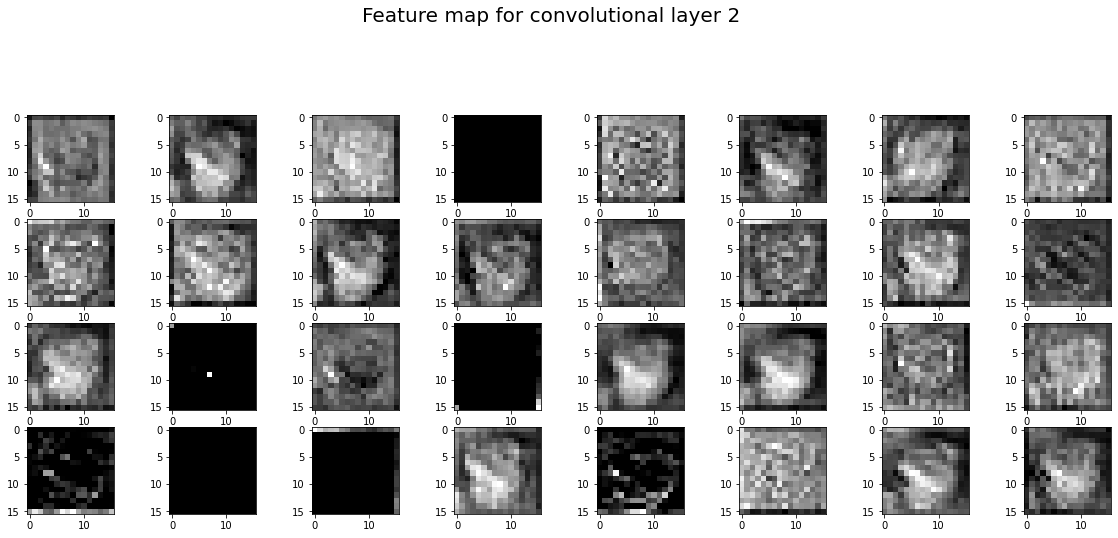

In [28]:
# Get the feature maps 
model = autoencoder.encoder
construct_feature_map(model, X_train)

## Colorization

Adapt the previous 'best' model to recolorize images from greyscale to RGB

In [11]:
# Prepare additional transformations required for colorization using an autoencoder
def to_grayscale(image):
    image = tf.image.rgb_to_grayscale(image)
    return image

datagen_gray = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=to_grayscale
)

In [12]:
#Creating a copy of the train array to convert to greyscale
X_train_gray = X_train.copy()

In [13]:
# TAKES A MINUTE ON MY COMPUTER

# Apply the transformation
trans_train_gray = datagen_gray.flow(X_train_gray, batch_size=len(X_train),shuffle=False)
trans_test_gray = datagen_gray.flow(X_test, batch_size=len(X_test),shuffle=False)
trans_val_gray = datagen_gray.flow(X_val, batch_size=len(X_val),shuffle=False)

# Store the transformed GRAY images
X_train_gray = trans_train_gray.next()
X_test_gray = trans_test_gray.next()
X_val_gray = trans_val_gray.next()

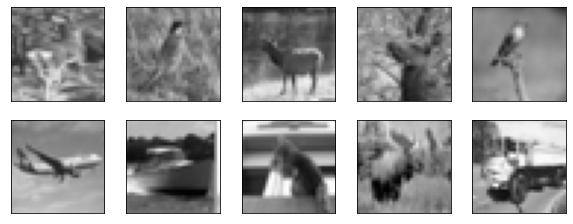

In [14]:
# Plot the images just to be sure the transformations worked

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_gray[i])
plt.show()

In [15]:
# Train the colorization model
history = autoencoder.fit(X_train_gray, X_train, epochs=10, batch_size=64,
                          validation_data=(X_val_gray, X_val))

Epoch 1/10
750/750 [==============================] - 28s 37ms/step - loss: 0.0098 - mse: 0.0098 - accuracy: 0.4384 - val_loss: 0.0096 - val_mse: 0.0096 - val_accuracy: 0.4472
Epoch 2/10
750/750 [==============================] - 26s 35ms/step - loss: 0.0095 - mse: 0.0095 - accuracy: 0.4460 - val_loss: 0.0093 - val_mse: 0.0093 - val_accuracy: 0.4734
Epoch 3/10
750/750 [==============================] - 26s 35ms/step - loss: 0.0094 - mse: 0.0094 - accuracy: 0.4531 - val_loss: 0.0092 - val_mse: 0.0092 - val_accuracy: 0.4333
Epoch 4/10
750/750 [==============================] - 26s 35ms/step - loss: 0.0093 - mse: 0.0093 - accuracy: 0.4567 - val_loss: 0.0093 - val_mse: 0.0093 - val_accuracy: 0.4119
Epoch 5/10
750/750 [==============================] - 27s 36ms/step - loss: 0.0093 - mse: 0.0093 - accuracy: 0.4586 - val_loss: 0.0091 - val_mse: 0.0091 - val_accuracy: 0.4614
Epoch 6/10
750/750 [==============================] - 27s 36ms/step - loss: 0.0092 - mse: 0.0092 - accuracy: 0.4632 - va

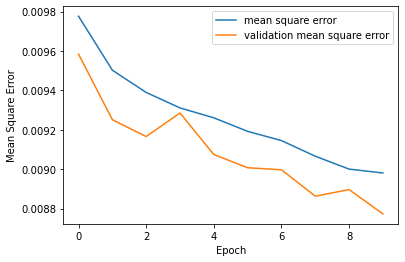

In [16]:
# Plot the valuation metrics
plt.plot(history.history['mse'], label='mean square error')
plt.plot(history.history['val_mse'], label = 'validation mean square error')
plt.xlabel('Epoch')
plt.ylabel('Mean Square Error')
plt.legend(loc='upper right')

In [17]:
# Make the predictions
predictions = autoencoder.predict(X_test_gray[:])

# Evaluate the predictions 
evaluation = autoencoder.evaluate(predictions, X_test)
print(f"\nLoss: {round(evaluation[0],4)}\nMSE: {round(evaluation[1],4)}\nAccuracy: {round(evaluation[2],4)}")

188/188 [==============================] - 1s 7ms/step - loss: 0.0105 - mse: 0.0105 - accuracy: 0.4936

Loss: 0.0105
MSE: 0.0105
Accuracy: 0.4936


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


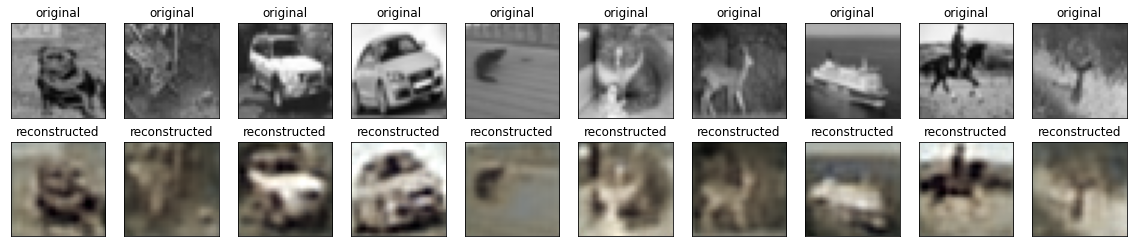

In [18]:
# Check the predictions 
n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_gray[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predictions[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
autoencoder.encoder.summary()
model = autoencoder.encoder
construct_feature_map(model, X_train)